# Project: Train a Quadcopter How to Fly


## Controlling the Quadcopter


In [1]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

In [2]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 20.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

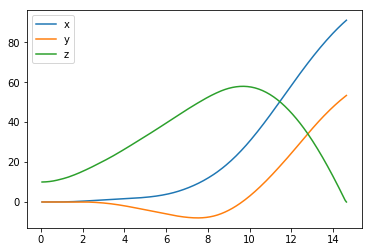

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

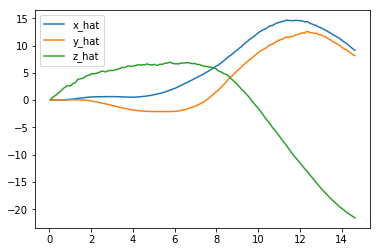

In [4]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

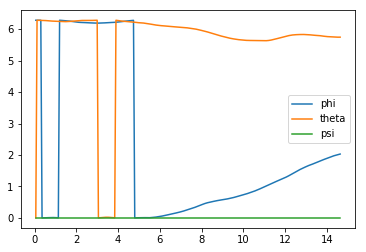

In [5]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

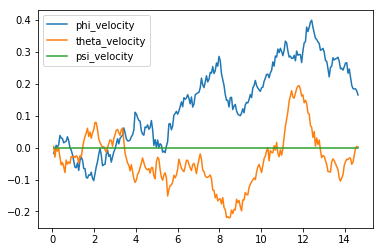

In [6]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

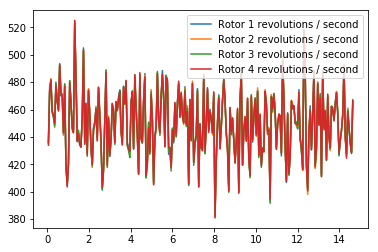

In [7]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

In [8]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[91.04484942 53.36168892  0.          2.03008746  5.74520227  0.        ]
[  9.13203918   8.17122435 -21.59758449]
[0.16492284 0.00200633 0.        ]


## The Task

## The Agent

In [27]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -1.443 (best =   0.048), noise_scale = 3.25

In [1]:
import sys
import pandas as pd
import numpy as np
from agents.agent import DDPG
from task import Task
import matplotlib.pyplot as plt
%matplotlib inline

Start = True

Using TensorFlow backend.


In [2]:
from importlib import reload 
import task
reload(task)
from task import Task
Start = True

In [14]:
from importlib import reload 
import task
reload(task)
from task import Task

from agents.agent import DDPG

# Settings
num_episodes = 100
runtime = 5.0
init_pose = np.array([0.0, 0.0, 10.0, 0.0, 0.0, 0.0])
target_pos = np.array([0.0, 0.0, 0.0])
init_velocities = [0., 0., 0.]
init_angle_velocities = [0., 0., 0.]

# Setup task and agent
task = Task(init_pose=init_pose, init_velocities=init_velocities, 
            init_angle_velocities=init_angle_velocities, runtime=runtime, target_pos=target_pos)
task.action_high = 800

# Restart training?
if Start:
    agent = DDPG(task)
    scores = []
    grades = []
    avg_reward = []
    best_score = -np.inf
    
# Give agent control
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() 
    score = 0.0
    steps = 0
    while True:
        action = agent.act(state) 
        next_state, reward, done = agent.task.step(action)
        agent.step(action, reward, next_state, done)
        
        state = next_state
        score += reward
        steps += 1
        if done:
            break
            
    avg_reward.append(score/max(1, steps))
    scores.append(score)
    if score > best_score:
        best_score = score 

    text = "\r"
    text += "Episode: {:4d}, ".format(len(scores))
    text += "score: {:.1f}, ".format(score)
    text += "avg_score: {:.1f}, ".format(np.mean(scores[-25:]))
    text += "best: {:.1f}, ".format(best_score)
    text += "avg_reward: {:.1f}, ".format(avg_reward[-1])
    text += "memory: {} ".format(len(agent.memory))
    text += "  "
    print(text, end="")
    sys.stdout.flush()
    
Start = False

Episode:  400, score: 143.4, avg_score: 167.1, best: 563.6, avg_reward: 6.8, memory: 10525   

## Plot the Rewards


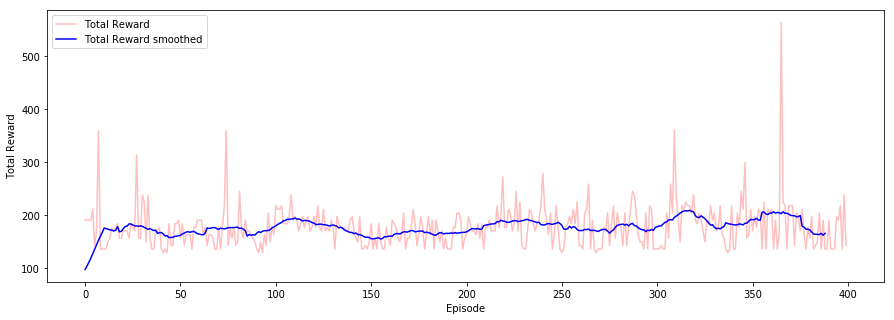

In [20]:
plt.figure(figsize=(15,5))
plt.plot(scores, alpha=0.25, color='red', label='Total Reward')
smooth = 21
plt.plot(np.convolve(scores, np.ones(smooth)/smooth)[(smooth-1)//2:-smooth], color='blue', label='Total Reward smoothed')
plt.ylabel('Total Reward')
plt.legend()
plt.xlabel("Episode")
plt.show()

## Sampling the model for one episode

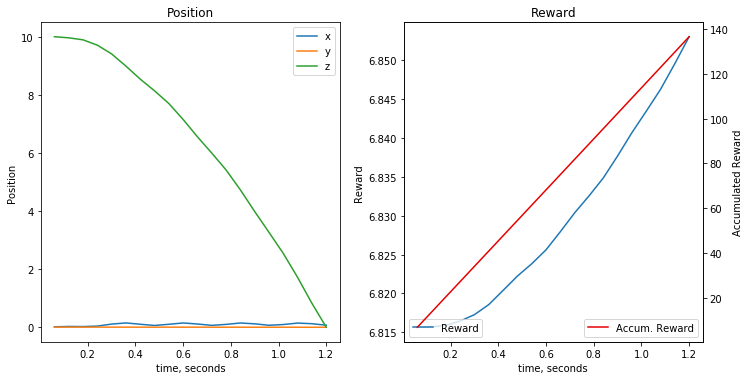

In [18]:
from importlib import reload 
import plot_fcts
reload(plot_fcts)
results = plot_fcts.log_run(agent, agent.task, 'DDPG.csv')
plot_fcts.plot_run(results)

## Results discussion


The task given here is a landing task where the quadcopter should move vertically from position (0,0,10) down to position (0,0,10). The agent uses the position, the velocity, the Euler angle, and angle velocity as a state. The reward function depends only on the difference between the current position and the target:

`reward = 1 - 0.003*(abs(self.sim.pose[:3] - self.target_pos)`

I clipped the function between -1 and +1 by applying a tanh function. Such clipping would prevent high positive or negative values on the reward and avoid gradient explosion.

`reward = np.tanh(reward)).sum()`

I tested to use the reward function without clipping, but the algorithm seemed to become unstable.

**Actor/Critic**

The learning algorithm that I tried is the DDPG algorithm that modelizes and Actor/Critic agent on a continous state and action spaces. The underlying policy function of DDPG is deterministic in nature but noise is added to actions externally to produce the desired stochasticity. Orginally, the actor used a deep neural network of three layers sized 32, 64 and 32 with a ReLU activation functions. The critic, in the other hand, had two layers sized 32 and 64 using ReLU activation functions as well. The critic combines two inputs: states and actions to calculate Q_values. The parameters of the critic NN are then used by the actor during the training phase to improve the policy.

With this structure I noted that there was not much learning and the total reward was oscillating more often. I decided to use two layers in both Critic and Actor NN with dimensions 500 and 300. I noted an increase in stability and performance and a better reward curve over episodes.

I used a discount factor $\gamma$ of 0.99  and a soft update parameter of $\tau$ of 0.001. The model was trained 400 episodes with a batch size of 128.


**Difficulties**

At first, after watching the videos and reading the paper on DDPG, I thought the training was going to be straightforward, but I took me many hours to make the first version of the code and a high number of tests all failed. But each failure, was a lesson because it led to questionning and looking for the reasons behind the failure. For every change in the reward function, the behavior of the agent changed. Often the average reward increases then reaches a plateau with no significant progress. Each training result has a different performance. Sometimes all curves are smooth, and sometimes everything oscillates.

Initially I used a reward function that is a linear combination of the error on the position, the sinus of angles and absolute angle velocity. Indeed, landing requires the vertical position to decrease progressively, as well as near zero values en euler angles and angles velocity to maintain a horizontal baseline of the quadcopter. But it seemed that this reward function, even after clipping, was taking into account too many parameters and the learning wasn't stable. I decided to  use the error on position as the only basis for reward. I hope discovering much complex reward functions in future RL projects.

I suppose that incresing the dimension of the internal layer of the neural networks of the actor and the critic is a good idea with a positive impact on learning. Clipping the reward function was also beneficial and help mitigating the exploding gradient problem.

I also tried to modify the agent to apply the same action on all rotors to maintain a horizontal position of the quadcopter, but maybe the way I did it wasn't correct (I copied the value of rotor1 into all other components of the action vector). I suppose that the right approach in this case would be to update both critic and actor models to consider only one output instead of four. But again, in case there is any noise, the quadcopter needs to adjust the power of each rotor independently. Therefore, a unique output does not seem to be the best startegy.

**Model behavior**:

The result of the current parameters adjustement show a total reward that increases during the first 50 episodes then stablizes around 200. Improvement can be made as we note peaks on the non smoothed reward curve meaning the model was able to produce a better reward by applying more robust actions on rotors. The position of the quadcopter also goes down from (0,0,10) to (0,0,0) as expected, but I think improvement should be done over angles to make sure the quadcopter lands while staying horizontal and with no rotation on Euler angles. I guess this can be improved by considering the angles and their velocities in the reward function.

The hardest part of the project was fine tuning parameters and determining the reward function because of the variety of possibilities that all make sense theoritically but do not necessarily work in practice. A landing task requires keeping the quadcopter as horizontal as possible while moving down. This requires maintaining euler angles and angular velocities near zero. Constructing a reward function by applying a coefficient for each one of these parameters is not intuitive. Sometimes it seems that focusing only on position may be the only factor in the reward, which is the approach that I followed in the end, but simulations show that this is not enough for a smooth landing. 

In the other hand, it seems intuitive that to make the quadcopter move down, all rotors should rotate at the same descreasing speed, but as the model is defined here, rotors are controlled separately. I think that in the special case of landing or taking off vertically, the problem can be simplified to calculating one command that can be applied to all rotors. The dimensionality of the input may also be reduced to position, velocity and euler angles only. This may be be studied further.

The behavior of the learning process is interesting and sometimes erratic. There are many parameters to control and experiment: batch size, discount factor, soft update parameter, reward, neural networks dimensionnality ... but I think that the parameters should be carefully chosen and changed in small steps to insure a smooth learning, otherwise oscillation and lack of convergence may occur.